# DxD == CxC == DxC

In [202]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)

def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere
    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)
    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)
    
    return RA, DEC

def uniform_random_on_sphere(data, size = None ):
    ra = data['RA']
    dec = data['DEC']
    
    n_features = ra.size
    #size = 100 * data.size
    
    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 size)
    #data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    #data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T
    
    #random redshift distribution
    mu, sigma = np.mean(data['DESDM_ZP']), np.std(data['DESDM_ZP'])
    z_R = np.random.normal(mu, sigma, size)
    
    data_R = np.zeros((ra_R.size,), dtype=[('RA', 'float'), ('DEC', 'float'), ('DESDM_ZP', 'float')])
    data_R['RA'] = ra_R
    data_R['DEC'] = dec_R
    data_R['DESDM_ZP'] = z_R
                              
    return data_R


In [203]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [204]:
# sgc data
import esutil
import numpy as np

path = '/n/des/lee.5922/data/cmass_cat/'

cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
#cmass_sgc = cmass_sgc[(cmass_sgc['Z'] > 0.43) & (cmass_sgc['Z'] < 0.7)]
random_sgc = esutil.io.read(path+'random0_DR12v5_CMASS_South.fits.gz')
#random_sgc = random_sgc[(random_sgc['Z'] > 0.43) & (random_sgc['Z'] < 0.7)]
cmass_st82 = Cuts.keepGoodRegion(cmass_sgc)

In [98]:
# dmass spt
dmass_spt = fitsio.read('result_cat/dmass_spt_30.fits')
gold_prob_cat = fitsio.read('result_cat/gold_st82_prob.fits')
dmass_st82, _ = resampleWithPth( gold_prob_cat, pstart = 0, pmax = 1.0 )

In [101]:
dmass_st82.shape, dmass_spt.shape

((11244,), (110270,))

In [9]:
random_spt = uniform_random_on_sphere(dmass_spt, size = 50 * dmass_spt.size)
random_spt = Cuts.keepGoodRegion(random_spt)

In [12]:
#tree corr
from systematics_module.corr import angular_correlation
angular_correlation(data = dmass_spt, rand = GoldMask_spt, weight = None, njack = 30, suffix = '_dmass_spt_30_test', out = None)
#angular_correlation(data = dmass_spt, rand = random_spt, weight = None, njack = 30, suffix = '_dmass_spt_rand', out = None)
w_sgc = cmass_sgc['WEIGHT_SYSTOT']*( cmass_sgc['WEIGHT_CP'] + cmass_sgc['WEIGHT_NOZ'] - 1. )
w_rand = random_sgc['WEIGHT_FKP']
data = angular_correlation(data = cmass_sgc, rand = random_sgc, njack = 30, weight = [w_sgc, w_rand], suffix = '_cmass_sgc_noz', out = None)

calculate angular correlation function
X (664, 2)  centers (30, 2)  tol=1e-05  maxiter=200
22 iterations  cluster sizes: [28 12 34 16 16 19 24 20 25 18 24 30 23 23 27 25 16 16 28 24 10 24 24 38 34
 12 28 19 19  8]
X (110270, 2)  centers (30, 2)  tol=1e-05  maxiter=200
27 iterations  cluster sizes: [4795 3812 4059 2933 3287 2885 3404 2843 4331 3519 3962 3591 3971 3444 4623
 4532 3664 2682 3678 3891 2925 4464 4219 3667 3830 2913 3065 4034 4649 2598]
saving data file to :  data_txt/acf_comparison_dmass_spt_30_test.txt
calculate angular correlation function
X (960, 2)  centers (30, 2)  tol=1e-05  maxiter=200
19 iterations  cluster sizes: [34 38 23 24 37 34 25 27 37 34 20 36 20 14 48 30 52 24 29 26 38 15 46 24 42
 50 22 33 27 51]
X (230831, 2)  centers (30, 2)  tol=1e-05  maxiter=200
109 iterations  cluster sizes: [ 8103  6270  7256  7733  8649  7787  7854  7961  7211  8240  8171  7951
  5870  6012  7412  6019 10255  7373  8318  8554  8286  7282  8362  8541
  7175  8237  6575  7827  6559  8

KeyboardInterrupt: 

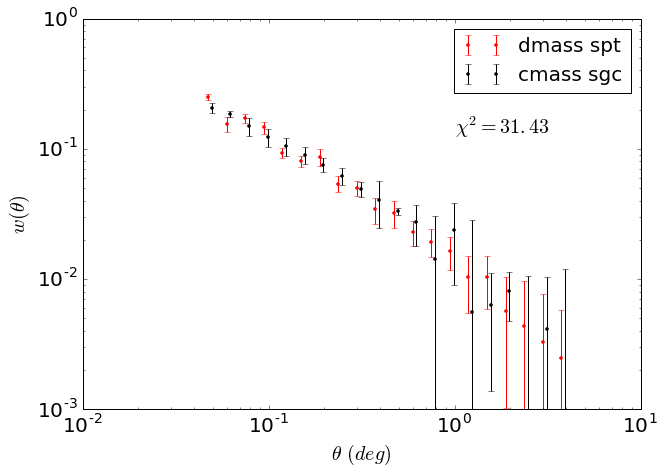

In [14]:
#DAT = np.loadtxt('data_txt/acf_comparison_dmass_spt.txt')
DAT = np.loadtxt('data_txt/acf_comparison_dmass_spt_30_test.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]
DAT2 = np.loadtxt('data_txt/acf_comparison_cmass_sgc_noz.txt')
meanr2, xi2, xi_err2 = [DAT2[:,i] for i in range(3)]
#DAT3 = np.loadtxt('data_txt/acf_comparison_cmass_sgc_noz.txt')
#meanr3, xi3, xi_err3 = [DAT3[:,i] for i in range(3)]

fig, ax = plt.subplots(figsize = (10, 7))
ax.errorbar(meanr, xi, yerr = xi_err, fmt = '.r', label='dmass spt')
ax.errorbar(meanr2*1.05, xi2, yerr = xi_err2, fmt = '.k', label='cmass sgc')
#ax.errorbar(meanr3*0.95, xi3, yerr = xi_err3, fmt = '.b', label='dmass spt rand')

chisqr = np.sum((xi - xi2)**2/xi_err**2 )
chisqr_dof = np.sum((xi - xi2)**2/xi_err**2 )/xi.size

ax.text(1,0.13,r'$\chi^2 = {:>0.2f}$'.format(chisqr), fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 20)
ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$ $(deg)$', size=20)
ax.set_ylabel(r'$w(\theta)$', size=20)

ax.tick_params(labelsize = 20)
#fig.savefig('figure/acf_comparison.pdf')
#fig.savefig('figure/acf_comparison.png')

In [24]:
np.sum((xi - xi2)**2/xi_err**2 ), np.sum((xi - xi2)**2/xi_err**2 )/xi.size

(32.554344724502975, 1.6277172362251489)

In [46]:
#tree corr
from systematics_module.corr import two_point_function
#two_point_function(data = dmass_spt, rand = GoldMask_spt, ztag = 'DESDM_ZP', suffix = '_dmass_spt')
#angular_correlation(data = dmass_spt, rand = random_spt, weight = None, suffix = '_dmass_spt_rand', out = None)
w_sgc = cmass_sgc['WEIGHT_SYSTOT']*( cmass_sgc['WEIGHT_CP'] + cmass_sgc['WEIGHT_NOZ'] - 1. )
w_rand = random_sgc['WEIGHT_FKP']
two_point_function(data = cmass_sgc, rand = random_sgc, njack = 2, ztag = 'Z', weight = [w_sgc, w_rand], suffix = '_cmass_sgc_z')

calculate angular correlation function
X (960, 2)  centers (2, 2)  tol=1e-05  maxiter=200
8 iterations  cluster sizes: [468 492]
X (230831, 2)  centers (2, 2)  tol=1e-05  maxiter=200
7 iterations  cluster sizes: [106492 124339]
saving data file to :  data_txt/acf_comparison_cmass_sgc_z.txt


0

In [20]:
# calling cmass
#cmass = io.getSGCCMASSphotoObjcat()
#cmass_st82 = Cuts.keepGoodRegion(cmass)

#cmass = Cuts.SpatialCuts(cmass, ra=320, ra2=360, dec=-2, dec2=2)
#m1, m2, _ = esutil.htm.HTM(10).match(cmass_st82['RA'], cmass_st82['DEC'], gold_prob_cat['RA'], \
#                                     gold_prob_cat['DEC'], 1./3600, maxmatch=1)
#cmass_mask = np.zeros(gold_prob_cat.size, dtype=bool)
#cmass_mask[m2] = 1
#clean_cmass_data_des, nocmass = gold_prob_cat[cmass_mask], gold_prob_cat[~cmass_mask]


--------------------------------
 calling BOSS SGC CMASS catalog
--------------------------------
Applying Healpix BOSS SGC footprint mask
Change healpix mask to spatial cut later..... Don't forget!!! 


In [205]:
# Generate randoms 
data_R = uniform_random_on_sphere(dmass_st82, size = 100 * dmass_st82.size)
data_R = Cuts.keepGoodRegion(data_R)
data_R_t = Cuts.keepGoodRegion(random_sgc)
#data_R_t = uniform_random_on_sphere(cmass_st82, size = 50 * cmass_st82.size)
#data_R_t = Cuts.keepGoodRegion(data_R_t)

In [206]:
dmass_st82.size, cmass_st82.size

(11244, 11908)

In [219]:
from systematics_module.corr import angular_correlation,cross_angular_correlation
angular_correlation(data = dmass_st82, rand = data_R, weight = None, suffix = '_dmass_st82', njack = 10, out = None)
angular_correlation(data = cmass_st82, rand = data_R_t, weight = None, suffix = '_cmass_st82_random_sgc', njack = 10, out = None)
cross_angular_correlation(data = cmass_st82, data2 = dmass_st82, rand = data_R_t, rand2= data_R, njack = 10,\
                          weight = None, suffix = '_cmass_dmass_st82', out=None)

X (218, 2)  centers (10, 2)  tol=1e-05  maxiter=200
13 iterations  cluster sizes: [23 31 31 14 12 27 12 16 33 19]
X (11908, 2)  centers (10, 2)  tol=1e-05  maxiter=200
45 iterations  cluster sizes: [1364 1757 1663  821  875 1032  963 1060 1382  991]
saving data file to :  data_txt/acf_cross_cmass_dmass_st82.txt


In [120]:
angular_correlation(data = cmass_sgc,
                    rand = random_sgc, 
                    weight = None, 
                    suffix = '_cmass_sgc', 
                    njack = 10)

calculate angular correlation function
X (960, 2)  centers (10, 2)  tol=1e-05  maxiter=200
30 iterations  cluster sizes: [104  93  83  88  99  98 100 111  94  90]
X (230831, 2)  centers (10, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [25078 23143 19985 23022 25798 22315 23057 23102 24109 21222]
saving data file to :  data_txt/acf_comparison_cmass_sgc.txt


0

In [220]:
DAT = np.loadtxt('data_txt/acf_comparison_dmass_st82.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]
DAT2 = np.loadtxt('data_txt/acf_comparison_cmass_st82_random_sgc.txt')
meanr2, xi2, xi_err2 = [DAT2[:,i] for i in range(3)]
DAT3 = np.loadtxt('data_txt/acf_cross_cmass_dmass_st82.txt')
meanr3, xi3, xi_err3 = [DAT3[:,i] for i in range(3)]

In [165]:
DAT_true = np.loadtxt('data_txt/acf_comparison_cmass_sgc.txt')
meanr_true, xi_true, xi_err_true = [DAT_true[:,i] for i in range(3)]

In [221]:
#cmass st82
chisqr_dmass = np.sum( (xi-xi2)**2/xi_err**2 )*1./xi2.size
#chisqr_cmass = np.sum( (xi2-xi_true)**2/xi_err2**2 )*1./xi_true.size
chisqr_cross = np.sum( (xi3-xi2)**2/xi_err3**2 )*1./xi2.size

In [222]:
chisqr_dmass, chisqr_cross

(0.91149364238039143, 1.2583286122355815)

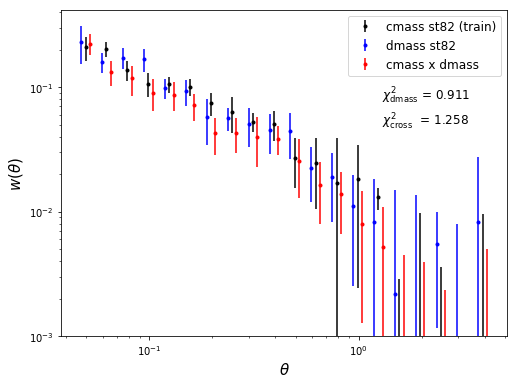

In [225]:
fig, ax = plt.subplots(figsize = (8,6))
ax.errorbar(meanr2*1.05, xi2, yerr = xi_err2, fmt = 'k.', label='cmass st82 (train)')
ax.errorbar(meanr, xi, yerr = xi_err, fmt = '.b', label='dmass st82')
ax.errorbar(meanr3*1.1, xi3, yerr = xi_err3, fmt = '.r', label='cmass x dmass')
#ax.errorbar(meanr_true, xi_true, yerr = xi_err_true, fmt = 'k--', label='CMASS SGC')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
ax.set_ylim(1e-3,)
ax.set_xlabel(r'$\theta$', fontsize = 15)
ax.set_ylabel(r'$w(\theta)$', fontsize =15)

ax.text(1.3, 0.08, r'$\chi_{\rm dmass}^2$ = '+'{:0.3f}'.format(chisqr_dmass), fontsize = 12)
ax.text(1.3, 0.05, r'$\chi_{\rm cross}^2$  = '+'{:0.3f}'.format(chisqr_cross), fontsize = 12)
fig.savefig('./figure/cross_cmass_dmass_st82.pdf')

figsave : figure/spatialtest_.png


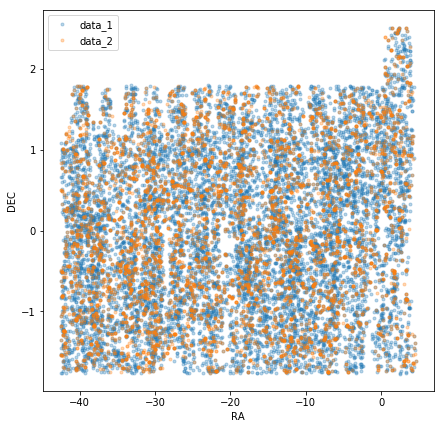

In [94]:
spatialcheck([cmass_st82, dmass_st82])